In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd

import os
from pathlib import Path

import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import random

# Data generation

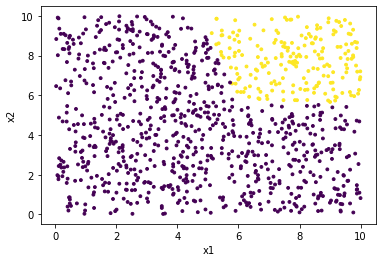

In [2]:
torch.manual_seed(42)

# generating fake data
# Here we generate some fake data
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def gen_nn_fake_data(n):
    x = np.random.uniform(0,10, (n, 2))
    x1 = x[:,0]
    x2 = x[:,1]
    score1 = sigmoid(-x1 - 8* x2 + 50)
    score2 = sigmoid(-7*x1 - 2* x2 + 50)
    score3 = 2* score1 + 3*score2 - 0.1
    y = score3 < 0
    return x, y.astype(int)

x, y = gen_nn_fake_data(1000)

plt.scatter(x[:,0],x[:,1],c=y, s=8);
plt.xlabel("x1"); plt.ylabel("x2");

In [3]:
x_train, y_train = torch.tensor(x[:700]).float(), torch.tensor(y[:700]).unsqueeze(dim=1).float()
x_valid, y_valid = torch.tensor(x[700:]).float(), torch.tensor(y[700:]).unsqueeze(dim=1).float()
print("- x_train size: {}".format(x_train.shape), ", y_train size: {}".format(y_train.shape))
print("- x_valid size: {}".format(x_valid.shape), ", y_valid size: {}".format(y_valid.shape))

- x_train size: torch.Size([700, 2]) , y_train size: torch.Size([700, 1])
- x_valid size: torch.Size([300, 2]) , y_valid size: torch.Size([300, 1])


# Dataset and dataloader


In [4]:
class dataset(Dataset):
    '''
    Input:
    - X values (xtensor) as a 2D torch tensor with dimension 
      [# of points, # of features]
    - Y values (ytensor) as a 1D torch tensor with dimension 
      [# of points,1]
      
    Output:
    - Torch Dataset for tabular data with a single output
    '''
    def __init__(self, xtensor, ytensor):
        self.x = xtensor
        self.y = ytensor
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx], idx


# ==================================================================================================
def make_DataLoaders(xtrain, xvalid, ytrain, yvalid,
                     batch_size=100000, num_workers = 0):
    """
    Input:
    -Torch tensors with xtrain, xvalid, ytrain, yvalid
    -Torch Dataset previously defined
    -batch size (integer)
    -Number of CPUs num_workers (integer)
    
    Output:
    -Torch DataLoaders for training, validation, and testing datasets. 
    """
# Create datasets
    train_dataset = dataset(xtrain, ytrain)
    valid_dataset = dataset(xvalid, yvalid)
    
# Create Dataloaders
    train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = True, 
                                                   num_workers=num_workers)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = False, 
                                                   num_workers=num_workers)
   
    return train_dataloader, valid_dataloader

In [5]:
# Create dataloaders : 
dl_train, dl_valid = make_DataLoaders(x_train, x_valid, y_train, y_valid,  
                                               batch_size=10)

# Model


In [6]:
class MyNetwork(nn.Module):    
    def __init__(self):
        """
        Input:
        - n_features
        - hiden layer
        - output layer
        """
        super(MyNetwork, self).__init__()
        self.hidden1 = nn.Linear(2,2)
        self.output = nn.Linear(2,1)
        
    def forward(self,x):
        x = F.relu(self.hidden1(x))
        x = self.output(x)
#        return torch.sigmoid(x)
        return x

In [7]:
model = MyNetwork()
model

MyNetwork(
  (hidden1): Linear(in_features=2, out_features=2, bias=True)
  (output): Linear(in_features=2, out_features=1, bias=True)
)

# Loss

In [8]:
#loss_func = nn.BCELoss(reduction='mean')
loss_func = nn.BCEWithLogitsLoss(reduction='mean')

# Device

In [9]:
# Select type of processor to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cuda'):
    print("-Type of precessor to be used: 'gpu'")
    !nvidia-smi
else:
    print("-Type of precessor to be used: 'cpu'")

-Type of precessor to be used: 'cpu'


# Training

In [10]:
def valid_epoch_clf(data_loader, model, loss_type, device):
    """
    Input:
    - data_loader: torch DataLoader previously created
    - model:       torch model previously trained
    - loss_type:   loss function previously created/instantiated
    - device: 'gpu' or 'cpu'
    
    Output:
    - Mean loss function over the entire data set
    """
# Put model in evaluation mode
    model.eval()
    loss_fun = 0.
    n_points = 0
    correct = 0

# Loop over mini batches (no gradients need to be computed)
    with torch.no_grad():
        for i, (xx, yy, _) in enumerate(data_loader, start=1):
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)
        
# .compute loss function
            batch_size = len(yy)
            loss = loss_type(yy_pred, yy)
            loss_fun += batch_size*loss.item()

# .compute accuracy
            class1 = yy_pred > 0.5
            correct += (class1.float() == yy).float().sum() 
           #y_pred.float change true and false to 1 and 0
            accuracy = correct/class1.shape[0]
        
# .number of points used after the ith mini-batch
            n_points += batch_size
        accuracy = correct/n_points
    return loss_fun/n_points, accuracy.item()

In [11]:
def train_epocs(model, epochs=10, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    path_loss = {}
    for n_epoch in range(epochs):
# ..Loop Over Mini-batches
        for ibatch, (xx, yy_true, _) in enumerate(dl_train, start=1):      
    #...Compute Train Loss (over minibatch)
            model.train()
            xx = xx.to(device)
            yy_true = yy_true.to(device)
            yy_pred = model(xx)
            loss = loss_func(yy_pred, yy_true)
            path_loss['train_loss'] = loss.item()
        
    #...Compute Gradients
            optimizer.zero_grad()
            loss.backward()

    #...Update Weights 
            optimizer.step()
        
     #...Compute Validation Loss
            path_loss['valid_loss'], accuracy = valid_epoch_clf(dl_valid, 
                                                                model, 
                                                                loss_func, 
                                                                device)
            print(n_epoch, "Train loss = {:.4f}".format(path_loss['train_loss']), "Val_loss = {:.4f}".format(path_loss['valid_loss']),
                     "Val Accuracy = {:.3f}".format(accuracy))

In [12]:
train_epocs(model, epochs=30)

0 Train loss = 0.8732 Val_loss = 0.8045 Val Accuracy = 0.600
0 Train loss = 0.8797 Val_loss = 0.7910 Val Accuracy = 0.637
0 Train loss = 0.9528 Val_loss = 0.7725 Val Accuracy = 0.657
0 Train loss = 0.6219 Val_loss = 0.7560 Val Accuracy = 0.683
0 Train loss = 0.8668 Val_loss = 0.7397 Val Accuracy = 0.717
0 Train loss = 0.6612 Val_loss = 0.7255 Val Accuracy = 0.753
0 Train loss = 0.7620 Val_loss = 0.7161 Val Accuracy = 0.773
0 Train loss = 0.6452 Val_loss = 0.7077 Val Accuracy = 0.800
0 Train loss = 1.1731 Val_loss = 0.7018 Val Accuracy = 0.820
0 Train loss = 0.8491 Val_loss = 0.6971 Val Accuracy = 0.830
0 Train loss = 1.1154 Val_loss = 0.6938 Val Accuracy = 0.830
0 Train loss = 0.9422 Val_loss = 0.6911 Val Accuracy = 0.833
0 Train loss = 0.7538 Val_loss = 0.6889 Val Accuracy = 0.833
0 Train loss = 0.4501 Val_loss = 0.6862 Val Accuracy = 0.833
0 Train loss = 0.7796 Val_loss = 0.6836 Val Accuracy = 0.833
0 Train loss = 0.6780 Val_loss = 0.6812 Val Accuracy = 0.833
0 Train loss = 0.5621 Va

1 Train loss = 0.5736 Val_loss = 0.5342 Val Accuracy = 0.833
1 Train loss = 0.5126 Val_loss = 0.5316 Val Accuracy = 0.833
1 Train loss = 0.8568 Val_loss = 0.5304 Val Accuracy = 0.833
1 Train loss = 0.5487 Val_loss = 0.5292 Val Accuracy = 0.833
2 Train loss = 0.5427 Val_loss = 0.5280 Val Accuracy = 0.833
2 Train loss = 0.5731 Val_loss = 0.5268 Val Accuracy = 0.833
2 Train loss = 0.4871 Val_loss = 0.5254 Val Accuracy = 0.833
2 Train loss = 0.7356 Val_loss = 0.5246 Val Accuracy = 0.833
2 Train loss = 0.6627 Val_loss = 0.5240 Val Accuracy = 0.833
2 Train loss = 0.5589 Val_loss = 0.5235 Val Accuracy = 0.833
2 Train loss = 0.7516 Val_loss = 0.5238 Val Accuracy = 0.833
2 Train loss = 0.6273 Val_loss = 0.5248 Val Accuracy = 0.833
2 Train loss = 0.5529 Val_loss = 0.5256 Val Accuracy = 0.833
2 Train loss = 0.5417 Val_loss = 0.5265 Val Accuracy = 0.833
2 Train loss = 0.4773 Val_loss = 0.5263 Val Accuracy = 0.833
2 Train loss = 0.5545 Val_loss = 0.5259 Val Accuracy = 0.833
2 Train loss = 0.5647 Va

3 Train loss = 0.3906 Val_loss = 0.4233 Val Accuracy = 0.833
3 Train loss = 0.5637 Val_loss = 0.4203 Val Accuracy = 0.833
3 Train loss = 0.5153 Val_loss = 0.4187 Val Accuracy = 0.833
3 Train loss = 0.3359 Val_loss = 0.4175 Val Accuracy = 0.833
3 Train loss = 0.4599 Val_loss = 0.4169 Val Accuracy = 0.833
3 Train loss = 0.4109 Val_loss = 0.4157 Val Accuracy = 0.833
3 Train loss = 0.4582 Val_loss = 0.4168 Val Accuracy = 0.833
4 Train loss = 0.4463 Val_loss = 0.4184 Val Accuracy = 0.837
4 Train loss = 0.3722 Val_loss = 0.4182 Val Accuracy = 0.840
4 Train loss = 0.5380 Val_loss = 0.4205 Val Accuracy = 0.843
4 Train loss = 0.3971 Val_loss = 0.4219 Val Accuracy = 0.850
4 Train loss = 0.5209 Val_loss = 0.4203 Val Accuracy = 0.850
4 Train loss = 0.4815 Val_loss = 0.4130 Val Accuracy = 0.840
4 Train loss = 0.3818 Val_loss = 0.4053 Val Accuracy = 0.833
4 Train loss = 0.4198 Val_loss = 0.3971 Val Accuracy = 0.833
4 Train loss = 0.4606 Val_loss = 0.3903 Val Accuracy = 0.833
4 Train loss = 0.2981 Va

5 Train loss = 0.3336 Val_loss = 0.3127 Val Accuracy = 0.917
5 Train loss = 0.4335 Val_loss = 0.3149 Val Accuracy = 0.923
5 Train loss = 0.3555 Val_loss = 0.3175 Val Accuracy = 0.923
5 Train loss = 0.2497 Val_loss = 0.3183 Val Accuracy = 0.927
5 Train loss = 0.4085 Val_loss = 0.3203 Val Accuracy = 0.933
5 Train loss = 0.3457 Val_loss = 0.3208 Val Accuracy = 0.937
5 Train loss = 0.4033 Val_loss = 0.3193 Val Accuracy = 0.933
5 Train loss = 0.2615 Val_loss = 0.3150 Val Accuracy = 0.927
5 Train loss = 0.3709 Val_loss = 0.3115 Val Accuracy = 0.923
5 Train loss = 0.2048 Val_loss = 0.3062 Val Accuracy = 0.917
5 Train loss = 0.3803 Val_loss = 0.3000 Val Accuracy = 0.907
5 Train loss = 0.4138 Val_loss = 0.2953 Val Accuracy = 0.887
6 Train loss = 0.3443 Val_loss = 0.2914 Val Accuracy = 0.877
6 Train loss = 0.1905 Val_loss = 0.2883 Val Accuracy = 0.860
6 Train loss = 0.2180 Val_loss = 0.2855 Val Accuracy = 0.853
6 Train loss = 0.2430 Val_loss = 0.2843 Val Accuracy = 0.843
6 Train loss = 0.3977 Va

7 Train loss = 0.2329 Val_loss = 0.2313 Val Accuracy = 0.923
7 Train loss = 0.2305 Val_loss = 0.2337 Val Accuracy = 0.933
7 Train loss = 0.2738 Val_loss = 0.2364 Val Accuracy = 0.940
7 Train loss = 0.2004 Val_loss = 0.2406 Val Accuracy = 0.943
7 Train loss = 0.2848 Val_loss = 0.2426 Val Accuracy = 0.943
7 Train loss = 0.2735 Val_loss = 0.2436 Val Accuracy = 0.947
7 Train loss = 0.2278 Val_loss = 0.2431 Val Accuracy = 0.947
7 Train loss = 0.2896 Val_loss = 0.2391 Val Accuracy = 0.943
7 Train loss = 0.2066 Val_loss = 0.2367 Val Accuracy = 0.943
7 Train loss = 0.2121 Val_loss = 0.2343 Val Accuracy = 0.940
7 Train loss = 0.2349 Val_loss = 0.2310 Val Accuracy = 0.940
7 Train loss = 0.1918 Val_loss = 0.2276 Val Accuracy = 0.927
7 Train loss = 0.2481 Val_loss = 0.2250 Val Accuracy = 0.923
7 Train loss = 0.3095 Val_loss = 0.2236 Val Accuracy = 0.917
7 Train loss = 0.2190 Val_loss = 0.2230 Val Accuracy = 0.917
7 Train loss = 0.3345 Val_loss = 0.2235 Val Accuracy = 0.923
7 Train loss = 0.2073 Va

9 Train loss = 0.1890 Val_loss = 0.1875 Val Accuracy = 0.940
9 Train loss = 0.3674 Val_loss = 0.1881 Val Accuracy = 0.940
9 Train loss = 0.3132 Val_loss = 0.1879 Val Accuracy = 0.940
9 Train loss = 0.1316 Val_loss = 0.1872 Val Accuracy = 0.940
9 Train loss = 0.4291 Val_loss = 0.1879 Val Accuracy = 0.940
9 Train loss = 0.2205 Val_loss = 0.1879 Val Accuracy = 0.940
9 Train loss = 0.1301 Val_loss = 0.1881 Val Accuracy = 0.940
9 Train loss = 0.2941 Val_loss = 0.1880 Val Accuracy = 0.940
9 Train loss = 0.1626 Val_loss = 0.1877 Val Accuracy = 0.940
9 Train loss = 0.1466 Val_loss = 0.1863 Val Accuracy = 0.940
9 Train loss = 0.1782 Val_loss = 0.1854 Val Accuracy = 0.940
9 Train loss = 0.2507 Val_loss = 0.1853 Val Accuracy = 0.940
9 Train loss = 0.3229 Val_loss = 0.1864 Val Accuracy = 0.940
9 Train loss = 0.1506 Val_loss = 0.1875 Val Accuracy = 0.943
9 Train loss = 0.1730 Val_loss = 0.1874 Val Accuracy = 0.940
9 Train loss = 0.3074 Val_loss = 0.1890 Val Accuracy = 0.947
9 Train loss = 0.1779 Va

11 Train loss = 0.0985 Val_loss = 0.1701 Val Accuracy = 0.953
11 Train loss = 0.1769 Val_loss = 0.1666 Val Accuracy = 0.947
11 Train loss = 0.2559 Val_loss = 0.1647 Val Accuracy = 0.947
11 Train loss = 0.0805 Val_loss = 0.1630 Val Accuracy = 0.940
11 Train loss = 0.2260 Val_loss = 0.1632 Val Accuracy = 0.943
11 Train loss = 0.2718 Val_loss = 0.1655 Val Accuracy = 0.947
11 Train loss = 0.2800 Val_loss = 0.1675 Val Accuracy = 0.950
11 Train loss = 0.0874 Val_loss = 0.1700 Val Accuracy = 0.953
11 Train loss = 0.2809 Val_loss = 0.1727 Val Accuracy = 0.953
11 Train loss = 0.1960 Val_loss = 0.1718 Val Accuracy = 0.953
11 Train loss = 0.0579 Val_loss = 0.1710 Val Accuracy = 0.953
11 Train loss = 0.4639 Val_loss = 0.1759 Val Accuracy = 0.953
11 Train loss = 0.0926 Val_loss = 0.1791 Val Accuracy = 0.957
11 Train loss = 0.2144 Val_loss = 0.1776 Val Accuracy = 0.957
11 Train loss = 0.2557 Val_loss = 0.1750 Val Accuracy = 0.953
11 Train loss = 0.1910 Val_loss = 0.1727 Val Accuracy = 0.953
11 Train

13 Train loss = 0.2165 Val_loss = 0.1491 Val Accuracy = 0.927
13 Train loss = 0.1639 Val_loss = 0.1472 Val Accuracy = 0.933
13 Train loss = 0.1736 Val_loss = 0.1462 Val Accuracy = 0.940
13 Train loss = 0.0985 Val_loss = 0.1455 Val Accuracy = 0.940
13 Train loss = 0.1582 Val_loss = 0.1452 Val Accuracy = 0.943
13 Train loss = 0.2214 Val_loss = 0.1451 Val Accuracy = 0.943
13 Train loss = 0.0368 Val_loss = 0.1452 Val Accuracy = 0.947
13 Train loss = 0.3183 Val_loss = 0.1455 Val Accuracy = 0.950
13 Train loss = 0.2894 Val_loss = 0.1462 Val Accuracy = 0.950
13 Train loss = 0.1787 Val_loss = 0.1480 Val Accuracy = 0.953
13 Train loss = 0.2135 Val_loss = 0.1478 Val Accuracy = 0.953
13 Train loss = 0.0665 Val_loss = 0.1470 Val Accuracy = 0.950
13 Train loss = 0.2221 Val_loss = 0.1481 Val Accuracy = 0.953
13 Train loss = 0.0763 Val_loss = 0.1484 Val Accuracy = 0.953
13 Train loss = 0.2698 Val_loss = 0.1497 Val Accuracy = 0.953
13 Train loss = 0.1636 Val_loss = 0.1510 Val Accuracy = 0.957
13 Train

15 Train loss = 0.0557 Val_loss = 0.1472 Val Accuracy = 0.950
15 Train loss = 0.0585 Val_loss = 0.1541 Val Accuracy = 0.950
15 Train loss = 0.0813 Val_loss = 0.1620 Val Accuracy = 0.940
15 Train loss = 0.2639 Val_loss = 0.1684 Val Accuracy = 0.943
15 Train loss = 0.2221 Val_loss = 0.1706 Val Accuracy = 0.943
15 Train loss = 0.0609 Val_loss = 0.1737 Val Accuracy = 0.943
15 Train loss = 0.4220 Val_loss = 0.1704 Val Accuracy = 0.943
15 Train loss = 0.1315 Val_loss = 0.1668 Val Accuracy = 0.940
15 Train loss = 0.1152 Val_loss = 0.1627 Val Accuracy = 0.940
15 Train loss = 0.2546 Val_loss = 0.1628 Val Accuracy = 0.937
15 Train loss = 0.1565 Val_loss = 0.1633 Val Accuracy = 0.937
15 Train loss = 0.2521 Val_loss = 0.1579 Val Accuracy = 0.947
15 Train loss = 0.2019 Val_loss = 0.1510 Val Accuracy = 0.950
15 Train loss = 0.1748 Val_loss = 0.1467 Val Accuracy = 0.953
15 Train loss = 0.0916 Val_loss = 0.1429 Val Accuracy = 0.953
15 Train loss = 0.0801 Val_loss = 0.1391 Val Accuracy = 0.953
15 Train

17 Train loss = 0.0214 Val_loss = 0.1281 Val Accuracy = 0.940
17 Train loss = 0.0211 Val_loss = 0.1289 Val Accuracy = 0.943
17 Train loss = 0.3600 Val_loss = 0.1287 Val Accuracy = 0.943
17 Train loss = 0.2936 Val_loss = 0.1279 Val Accuracy = 0.943
17 Train loss = 0.3100 Val_loss = 0.1277 Val Accuracy = 0.943
17 Train loss = 0.0909 Val_loss = 0.1274 Val Accuracy = 0.947
17 Train loss = 0.1802 Val_loss = 0.1273 Val Accuracy = 0.950
17 Train loss = 0.1605 Val_loss = 0.1283 Val Accuracy = 0.953
17 Train loss = 0.2323 Val_loss = 0.1286 Val Accuracy = 0.953
17 Train loss = 0.0890 Val_loss = 0.1289 Val Accuracy = 0.953
17 Train loss = 0.2415 Val_loss = 0.1303 Val Accuracy = 0.953
17 Train loss = 0.0350 Val_loss = 0.1321 Val Accuracy = 0.953
17 Train loss = 0.2319 Val_loss = 0.1348 Val Accuracy = 0.957
17 Train loss = 0.1414 Val_loss = 0.1387 Val Accuracy = 0.957
17 Train loss = 0.2045 Val_loss = 0.1443 Val Accuracy = 0.947
17 Train loss = 0.0885 Val_loss = 0.1479 Val Accuracy = 0.947
17 Train

19 Train loss = 0.0963 Val_loss = 0.1335 Val Accuracy = 0.953
19 Train loss = 0.0311 Val_loss = 0.1298 Val Accuracy = 0.960
19 Train loss = 0.0229 Val_loss = 0.1267 Val Accuracy = 0.957
19 Train loss = 0.0219 Val_loss = 0.1244 Val Accuracy = 0.953
19 Train loss = 0.1183 Val_loss = 0.1228 Val Accuracy = 0.953
19 Train loss = 0.1309 Val_loss = 0.1213 Val Accuracy = 0.953
19 Train loss = 0.0625 Val_loss = 0.1211 Val Accuracy = 0.950
19 Train loss = 0.0904 Val_loss = 0.1217 Val Accuracy = 0.947
19 Train loss = 0.2145 Val_loss = 0.1215 Val Accuracy = 0.950
19 Train loss = 0.1054 Val_loss = 0.1217 Val Accuracy = 0.947
19 Train loss = 0.0538 Val_loss = 0.1216 Val Accuracy = 0.950
19 Train loss = 0.1600 Val_loss = 0.1210 Val Accuracy = 0.950
19 Train loss = 0.0660 Val_loss = 0.1207 Val Accuracy = 0.950
19 Train loss = 0.1765 Val_loss = 0.1210 Val Accuracy = 0.953
19 Train loss = 0.1444 Val_loss = 0.1219 Val Accuracy = 0.957
19 Train loss = 0.1810 Val_loss = 0.1237 Val Accuracy = 0.953
19 Train

21 Train loss = 0.3031 Val_loss = 0.1167 Val Accuracy = 0.950
21 Train loss = 0.0872 Val_loss = 0.1164 Val Accuracy = 0.953
21 Train loss = 0.0718 Val_loss = 0.1164 Val Accuracy = 0.953
21 Train loss = 0.1123 Val_loss = 0.1164 Val Accuracy = 0.953
21 Train loss = 0.1151 Val_loss = 0.1164 Val Accuracy = 0.953
21 Train loss = 0.1810 Val_loss = 0.1164 Val Accuracy = 0.953
21 Train loss = 0.0494 Val_loss = 0.1163 Val Accuracy = 0.953
21 Train loss = 0.1616 Val_loss = 0.1163 Val Accuracy = 0.953
21 Train loss = 0.0300 Val_loss = 0.1165 Val Accuracy = 0.950
21 Train loss = 0.1442 Val_loss = 0.1164 Val Accuracy = 0.950
21 Train loss = 0.2522 Val_loss = 0.1162 Val Accuracy = 0.953
21 Train loss = 0.2431 Val_loss = 0.1167 Val Accuracy = 0.953
21 Train loss = 0.1212 Val_loss = 0.1182 Val Accuracy = 0.953
21 Train loss = 0.1159 Val_loss = 0.1220 Val Accuracy = 0.960
21 Train loss = 0.1517 Val_loss = 0.1247 Val Accuracy = 0.957
21 Train loss = 0.1198 Val_loss = 0.1292 Val Accuracy = 0.953
21 Train

23 Train loss = 0.0739 Val_loss = 0.1578 Val Accuracy = 0.937
23 Train loss = 0.1216 Val_loss = 0.1620 Val Accuracy = 0.937
23 Train loss = 0.1393 Val_loss = 0.1682 Val Accuracy = 0.940
23 Train loss = 0.2975 Val_loss = 0.1703 Val Accuracy = 0.940
23 Train loss = 0.0962 Val_loss = 0.1678 Val Accuracy = 0.940
23 Train loss = 0.3702 Val_loss = 0.1575 Val Accuracy = 0.937
23 Train loss = 0.0264 Val_loss = 0.1484 Val Accuracy = 0.940
23 Train loss = 0.1338 Val_loss = 0.1403 Val Accuracy = 0.943
24 Train loss = 0.1534 Val_loss = 0.1354 Val Accuracy = 0.947
24 Train loss = 0.0855 Val_loss = 0.1297 Val Accuracy = 0.947
24 Train loss = 0.1425 Val_loss = 0.1265 Val Accuracy = 0.947
24 Train loss = 0.1621 Val_loss = 0.1233 Val Accuracy = 0.953
24 Train loss = 0.2154 Val_loss = 0.1201 Val Accuracy = 0.960
24 Train loss = 0.0725 Val_loss = 0.1189 Val Accuracy = 0.960
24 Train loss = 0.0279 Val_loss = 0.1181 Val Accuracy = 0.960
24 Train loss = 0.2127 Val_loss = 0.1199 Val Accuracy = 0.960
24 Train

25 Train loss = 0.0236 Val_loss = 0.1156 Val Accuracy = 0.943
26 Train loss = 0.0464 Val_loss = 0.1168 Val Accuracy = 0.943
26 Train loss = 0.0430 Val_loss = 0.1180 Val Accuracy = 0.943
26 Train loss = 0.1295 Val_loss = 0.1175 Val Accuracy = 0.943
26 Train loss = 0.1606 Val_loss = 0.1155 Val Accuracy = 0.947
26 Train loss = 0.0783 Val_loss = 0.1137 Val Accuracy = 0.950
26 Train loss = 0.0626 Val_loss = 0.1122 Val Accuracy = 0.950
26 Train loss = 0.3686 Val_loss = 0.1114 Val Accuracy = 0.953
26 Train loss = 0.0847 Val_loss = 0.1132 Val Accuracy = 0.953
26 Train loss = 0.1848 Val_loss = 0.1164 Val Accuracy = 0.957
26 Train loss = 0.0881 Val_loss = 0.1215 Val Accuracy = 0.950
26 Train loss = 0.2141 Val_loss = 0.1257 Val Accuracy = 0.947
26 Train loss = 0.2473 Val_loss = 0.1273 Val Accuracy = 0.940
26 Train loss = 0.1074 Val_loss = 0.1271 Val Accuracy = 0.947
26 Train loss = 0.0874 Val_loss = 0.1247 Val Accuracy = 0.947
26 Train loss = 0.1948 Val_loss = 0.1193 Val Accuracy = 0.950
26 Train

28 Train loss = 0.1967 Val_loss = 0.1183 Val Accuracy = 0.950
28 Train loss = 0.0578 Val_loss = 0.1186 Val Accuracy = 0.947
28 Train loss = 0.1470 Val_loss = 0.1169 Val Accuracy = 0.953
28 Train loss = 0.1928 Val_loss = 0.1139 Val Accuracy = 0.957
28 Train loss = 0.0205 Val_loss = 0.1117 Val Accuracy = 0.957
28 Train loss = 0.0219 Val_loss = 0.1102 Val Accuracy = 0.953
28 Train loss = 0.0796 Val_loss = 0.1095 Val Accuracy = 0.953
28 Train loss = 0.0971 Val_loss = 0.1092 Val Accuracy = 0.953
28 Train loss = 0.1335 Val_loss = 0.1095 Val Accuracy = 0.953
28 Train loss = 0.0417 Val_loss = 0.1105 Val Accuracy = 0.950
28 Train loss = 0.2167 Val_loss = 0.1110 Val Accuracy = 0.950
28 Train loss = 0.0820 Val_loss = 0.1110 Val Accuracy = 0.950
28 Train loss = 0.1143 Val_loss = 0.1103 Val Accuracy = 0.950
28 Train loss = 0.0400 Val_loss = 0.1097 Val Accuracy = 0.953
28 Train loss = 0.1185 Val_loss = 0.1092 Val Accuracy = 0.953
28 Train loss = 0.1673 Val_loss = 0.1096 Val Accuracy = 0.953
28 Train